# Requirements and initialisation

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd

import numpy as np
import xarray as xr

from dask.distributed import Client

import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as feature

# Load land features
land_50m = feature.NaturalEarthFeature(
    "physical",
    "land",
    "50m",
    edgecolor="black",
    facecolor="gray",
    linewidth=0.2,
)

# Start local Dask cluster
client = Client()

# Start COSIMA DB session
session = cc.database.create_session()

# Setup

In [2]:
EXPT = "01deg_jra55v13_ryf9091" # Experiment name
START_TIME = "1970-12-01"
END_TIME = "1970-12-31"

# Calculation

## Load variables

In [3]:
# To calculate EKE, we need horizontal velocities u & v w/ at least "1 daily" frequency
# To search for all available variables with "1 daily" frequency:
# cc.querying.get_variables(session, EXPT, frequency="1 daily")

u = cc.querying.getvar(
    expt=EXPT,                      # Name of experiment to load
    variable="u",                   # Name of variable to load
    session=session,                # COSIMA DB session
    ncfile="ocean_daily_3d_u_%.nc", # Load only files matching this string (% is a wildcard character)
    start_time=START_TIME,          # Only load data after this date
)

u = u.sel(time=slice(START_TIME, END_TIME))

v = cc.querying.getvar(
    expt=EXPT,                      # Name of experiment to load
    variable="v",                   # Name of variable to load
    session=session,                # COSIMA DB session
    ncfile="ocean_daily_3d_v_%.nc", # Load only files matching this string (% is a wildcard character)
    start_time=START_TIME,          # Only load data after this date
)

v = v.sel(time=slice(START_TIME, END_TIME))

## Depth-integrated total kinetic energy

  0%|          | 0/81 [00:00<?, ?it/s]

Text(0.5, 1.0, "TKE using CC's compute_by_block")

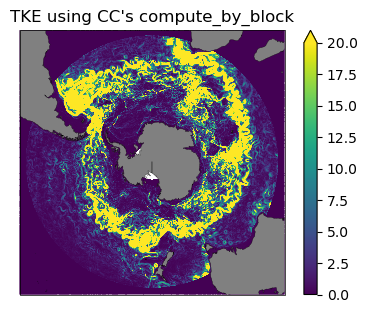

In [7]:
# Define depth-integrated total kinetic energy
ke = 0.5*(u**2 + v**2)
dz = np.gradient(ke.st_ocean)[:, np.newaxis, np.newaxis]
tke = (ke*dz).mean("time").sum("st_ocean")

# NB: xarray does not compute these expressions until we call compute explicitly due to the large data size
# Calling tke.compute() will likely fail

# Use CC to compute calculation by chunks
tke_computed = ccd.compute_by_block(tke)

# Plot
fig = plt.figure(figsize=(5, 3.5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
tke_computed.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=20)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("Total kinetic energy")

## Mean kinetic energy

  0%|          | 0/81 [00:00<?, ?it/s]

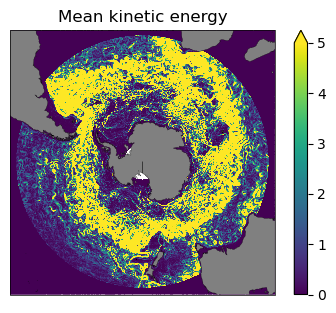

In [8]:
# Calculate mean kinetic energy
ke = 0.5*(u**2 + v**2)
u_mean = u.mean("time")
v_mean = v.mean("time")
dz = np.gradient(ke.st_ocean)[:, np.newaxis, np.newaxis]
mke = (0.5*(u_mean**2 + v_mean**2)*dz).sum("st_ocean")

# Use CC to compute by chunks
mke_computed = ccd.compute_by_block(mke)

# Plot
fig = plt.figure(figsize=(5, 3.5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
mke_computed.plot(ax=ax,transform=ccrs.PlateCarree(), vmax=5);
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("Mean kinetic energy");

## Eddy kinetic energy

  0%|          | 0/81 [00:00<?, ?it/s]

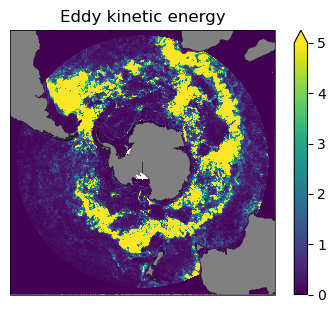

In [5]:
# Calculate eddy kinetic energy
ke = 0.5*(u**2 + v**2)
u_transient = u - u.mean("time")
v_transient = v - v.mean("time")
dz = np.gradient(ke.st_ocean)[:, np.newaxis, np.newaxis]
eke = (0.5*(u_transient**2 + v_transient**2)*dz).sum("st_ocean").mean("time")

# Use CC to compute by chunks
eke_computed = ccd.compute_by_block(eke)

# Plot
fig = plt.figure(figsize=(5, 3.5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection= ccrs.SouthPolarStereo())
eke_computed.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=5);
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("Eddy kinetic energy");